In [1]:
# #enable code folding
# !pip install msgpack
# !pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable codefolding/main

### Import Libraries

In [1]:
# Define IAM role
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

import boto3

import sagemaker
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role
role = get_execution_role()
%matplotlib inline

### Get the data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv')
pd.set_option('display.max_columns', 500)

### EDA

In [29]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
441,442,0,3,"Hampe, Mr. Leon",male,20.0,0,0,345769,9.5,NaN,S
426,427,1,2,"Clarke, Mrs. Charles V (Ada Maria Winfield)",female,28.0,1,0,2003,26.0,NaN,S
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0,E33,S
770,771,0,3,"Lievens, Mr. Rene Aime",male,24.0,0,0,345781,9.5,NaN,S
431,432,1,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.1,NaN,S


In [30]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [31]:
df.shape

(891, 12)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [33]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [34]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [36]:
# How Many people Survived?
df.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

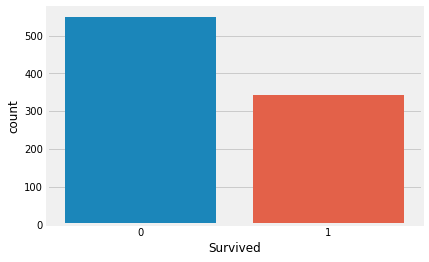

In [38]:
sns.countplot('Survived',data=df)

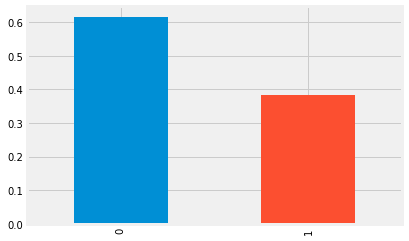

In [39]:
df.Survived.value_counts(normalize=True).plot(kind='bar')

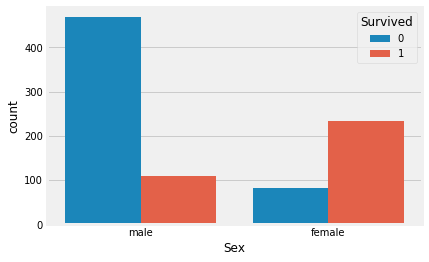

In [45]:
sns.countplot('Sex',hue='Survived',data=df)

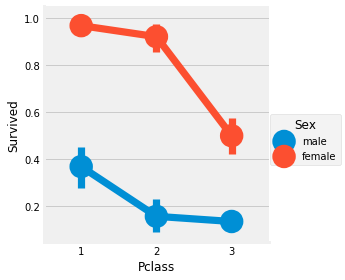

In [47]:
sns.factorplot('Pclass','Survived',hue='Sex',data=df)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56e2cb7550>,
      dtype=object)

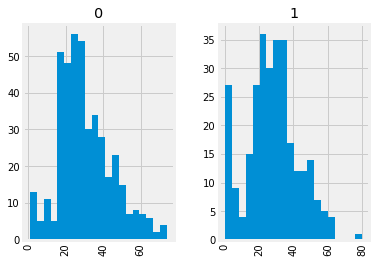

In [48]:
df.hist("Age",by="Survived",bins=20)

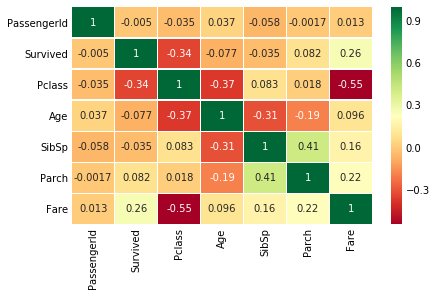

In [51]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)

### Data Preprocessing

In [56]:
#Filling Missing Values for Age

In [52]:
df['Initial']=0
for i in df:
    df['Initial']=df.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [55]:
df.Initial.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Capt          1
Sir           1
Mme           1
Jonkheer      1
Lady          1
Countess      1
Ms            1
Don           1
Name: Initial, dtype: int64

In [59]:
pd.crosstab(df.Initial,df.Sex).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [60]:
df['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                      ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [61]:
df.Initial.value_counts()

Mr        529
Miss      186
Mrs       127
Master     40
Other       9
Name: Initial, dtype: int64

In [62]:
df.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [64]:
## Assigning the NaN Values with the Ceil values of the mean ages
df.loc[(df.Age.isnull())&(df.Initial=='Mr'),'Age']=33
df.loc[(df.Age.isnull())&(df.Initial=='Mrs'),'Age']=36
df.loc[(df.Age.isnull())&(df.Initial=='Master'),'Age']=5
df.loc[(df.Age.isnull())&(df.Initial=='Miss'),'Age']=22
df.loc[(df.Age.isnull())&(df.Initial=='Other'),'Age']=46

In [65]:
# MIssing values for Embarked

In [67]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [68]:
df['Embarked'].fillna('S',inplace=True)

In [69]:
#New Fetaures... Family Size and Alone

In [71]:
df['Family_Size']=0
df['Family_Size']=df['Parch']+df['SibSp']#family size
df['Alone']=0
df.loc[df.Family_Size==0,'Alone']=1#Alone

In [72]:
#Droppping not needed features

In [75]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Family_Size,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,1


In [77]:
df.drop(["Name","Cabin","Ticket","PassengerId"],inplace=True,axis=1)

In [78]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Initial,Family_Size,Alone
0,0,3,male,22.0,1,0,7.2500,S,Mr,1,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,1,0
2,1,3,female,26.0,0,0,7.9250,S,Miss,0,1
3,1,1,female,35.0,1,0,53.1000,S,Mrs,1,0
4,0,3,male,35.0,0,0,8.0500,S,Mr,0,1


In [79]:
#Label Enconding

In [80]:
from sklearn.preprocessing import LabelEncoder

In [82]:
for col in df.columns:
    if df[col].dtype == "object":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [83]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Initial,Family_Size,Alone
0,0,3,1,22.0,1,0,7.2500,2,2,1,0
1,1,1,0,38.0,1,0,71.2833,0,3,1,0
2,1,3,0,26.0,0,0,7.9250,2,1,0,1
3,1,1,0,35.0,1,0,53.1000,2,3,1,0
4,0,3,1,35.0,0,0,8.0500,2,2,0,1


### Train Test Split

In [85]:
from sklearn.model_selection import train_test_split

In [93]:
train, test = train_test_split(df,test_size=0.2,random_state=0,stratify=df['Survived'])
train, validation = train_test_split(train,test_size=0.2,random_state=0,stratify=train['Survived'])

In [94]:
train.to_csv('train.csv', header=False, index=False)
validation.to_csv('validation.csv', header=False, index=False)
test.to_csv('test.csv', header=False, index=False)

In [95]:
bucket = ''
prefix = ''

In [97]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

### Model Training on Sagemaker

In [98]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

In [101]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [102]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/model'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(max_depth=10,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2018-09-05-15-51-41-287


.....................

Arguments: train
[2018-09-05:15:54:56:INFO] Running standalone xgboost training.
[2018-09-05:15:54:56:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8585.95mb
[2018-09-05:15:54:56:INFO] Determined delimiter of CSV input is ','
[15:54:56] S3DistributionType set as FullyReplicated
[15:54:56] 569x10 matrix with 5690 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-09-05:15:54:56:INFO] Determined delimiter of CSV input is ','
[15:54:56] S3DistributionType set as FullyReplicated
[15:54:56] 143x10 matrix with 1430 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[15:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[0]#011train-error:0.179262#011validation-error:0.181818
[15:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[1]#011t

Billable seconds: 91


### Hyper Parameter Optimization

In [110]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter    

hyperparameter_ranges = {'eta': ContinuousParameter(0.01, 0.2),
                         'num_round': IntegerParameter(100, 500),
                         'max_depth': IntegerParameter(3, 9),
                         'gamma': IntegerParameter(0, 5),
                         'min_child_weight': IntegerParameter(2, 6),
                         'subsample': ContinuousParameter(0.5, 0.9)}

objective_metric_name = 'validation:error'
objective_type='Minimize'
tuner = HyperparameterTuner(estimator = xgb, 
                    objective_metric_name = objective_metric_name , 
                    hyperparameter_ranges = hyperparameter_ranges, 
                    strategy='Bayesian', 
                    objective_type= objective_type, 
                    max_jobs=2, 
                    max_parallel_jobs=1)

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating hyperparameter tuning job with name: xgboost-180905-1644


In [118]:
def getTuningResults(tuning_job_name):
    sage_client = boto3.Session().client('sagemaker')
    tuning_job_name = tuning_job_name
    tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
    is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
    tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
    full_df = tuner.dataframe()

    if len(full_df) > 0:
        tuning_df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
        if len(tuning_df) > 0:
            tuning_df = tuning_df.sort_values('FinalObjectiveValue', ascending=is_minimize)
            print("Number of training jobs with valid objective: %d" % len(tuning_df))
            print({"lowest": min(tuning_df['FinalObjectiveValue']), "highest": max(tuning_df['FinalObjectiveValue'])})
            pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName
            return tuning_df
        else:
            print("No training jobs have reported valid results yet.")

    return full_df

In [119]:
getTuningResults("xgboost-180905-1644")

Number of training jobs with valid objective: 2
{'lowest': 0.16783200204372406, 'highest': 0.17482499778270721}


,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,eta,gamma,max_depth,min_child_weight,num_round,subsample
1,0.167832,93.0,2018-09-05 16:48:13+00:00,xgboost-180905-1644-001-07afe8a2,Completed,2018-09-05 16:46:40+00:00,0.081781,3.0,9.0,2.0,289.0,0.686471
0,0.174825,89.0,2018-09-05 16:51:43+00:00,xgboost-180905-1644-002-0b754796,Completed,2018-09-05 16:50:14+00:00,0.188926,0.0,3.0,3.0,482.0,0.658996


### Deploy Model

In [7]:
import numpy
from sagemaker.estimator import Estimator

In [8]:
model = Estimator.attach("")

Arguments: train
[2018-09-05:15:54:56:INFO] Running standalone xgboost training.
[2018-09-05:15:54:56:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8585.95mb
[2018-09-05:15:54:56:INFO] Determined delimiter of CSV input is ','
[15:54:56] S3DistributionType set as FullyReplicated
[15:54:56] 569x10 matrix with 5690 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-09-05:15:54:56:INFO] Determined delimiter of CSV input is ','
[15:54:56] S3DistributionType set as FullyReplicated
[15:54:56] 143x10 matrix with 1430 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[15:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[0]#011train-error:0.179262#011validation-error:0.181818
[15:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[1]#011train-error:0.179262#011

[97]#011train-error:0.14587#011validation-error:0.174825
[15:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 12 pruned nodes, max_depth=2
[98]#011train-error:0.14587#011validation-error:0.174825
[15:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[99]#011train-error:0.142355#011validation-error:0.174825
Billable seconds: 91


In [9]:
xgb_predictor = model.deploy(initial_instance_count=1,
                           instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: xgboost-2018-09-06-07-04-26-386
INFO:sagemaker:Creating endpoint with name xgboost-2018-09-05-15-51-41-287


----------------------------------------------------------------------------------------!

In [14]:
type(xgb_predictor)

sagemaker.predictor.RealTimePredictor

### Evaluate

In [11]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [15]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [16]:
test_data = pd.read_csv("test.csv")

In [17]:
predictions = predict(test_data.as_matrix()[:, 1:])

In [18]:
predictions[:10]

array([0.09979267, 0.26513603, 0.11607913, 0.94531691, 0.20655359,
       0.11395893, 0.359319  , 0.44781107, 0.10605118, 0.10974585])

In [19]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,98,11
1,25,44


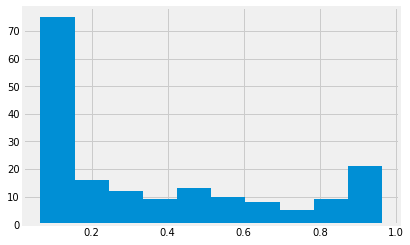

In [20]:
plt.hist(predictions)
plt.show()

In [23]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.7, 1, 0))

col_0,0,1
0,,
0,106,3
1,38,31


### Training on Docker

In [25]:
%%sh

# The name of our algorithm
algorithm_name=random-forest-titanic

cd docker

chmod +x random_forest/train
chmod +x random_forest/serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
#region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded

Step 1/9 : FROM ubuntu:16.04
16.04: Pulling from library/ubuntu
3b37166ec614: Pulling fs layer
504facff238f: Pulling fs layer
ebbcacd28e10: Pulling fs layer
c7fb3351ecad: Pulling fs layer
2e3debadcbf7: Pulling fs layer
c7fb3351ecad: Waiting
2e3debadcbf7: Waiting
ebbcacd28e10: Verifying Checksum
ebbcacd28e10: Download complete
504facff238f: Download complete
c7fb3351ecad: Verifying Checksum
c7fb3351ecad: Download complete
2e3debadcbf7: Verifying Checksum
2e3debadcbf7: Download complete
3b37166ec614: Verifying Checksum
3b37166ec614: Download complete
3b37166ec614: Pull complete
504facff238f: Pull complete
ebbcacd28e10: Pull complete
c7fb3351ecad: Pull complete
2e3debadcbf7: Pull complete
Digest: sha256:8c3671e5230c68aa7e797115f1752f9c3cc2679b7eb24813b0f1dee44e81ddd4
Status: Downloaded newer image for ubuntu:16.04
 ---> b9e15a5d1e1a
Step 2/9 : MAINTAINER Amazon AI <sage-learner@amazon.com>
 ---> Running in 6ba50673e2fc
Removing intermediate container 6ba50673e2fc
 ---> e7

WARNING! Using --password via the CLI is insecure. Use --password-stdin.


In [26]:
# Define IAM role
import boto3
import re
import sagemaker as sage
from time import gmtime, strftime
import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
sess = sage.Session()

In [27]:
data_location = ''
model_location = ''

In [28]:
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/random-forest-titanic'.format(account, region)

tree = sage.estimator.Estimator(image,
                        role, 1, 'ml.c4.2xlarge',
                        output_path=model_location,
                        sagemaker_session=sess)

In [29]:
tree.set_hyperparameters(max_leaf_nodes=2)

In [30]:
tree.fit(data_location)

INFO:sagemaker:Creating training-job with name: random-forest-titanic-2018-09-06-08-40-29-066


.............
Starting the training.
Training complete.

Billable seconds: 29
